In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Генерация данных
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [ ]:
# Vanilla SGD
def vanilla_sgd(X, y, lr=0.1, epochs=50):
    m = len(y)
    w = np.random.randn(2, 1) # [intercept, slope]
    X_b = np.c_[np.ones((m, 1)), X]
    history = []

    for epoch in range(epochs):
        for i in range(m):
            random_index = np.random.randint(m)
            xi = X_b[random_index:random_index+1]
            yi = y[random_index:random_index+1]
            gradients = 2 * xi.T.dot(xi.dot(w) - yi)
            w = w - lr * gradients
            history.append(np.sum((X_b.dot(w) - y)**2)/m)
    return w, history

In [ ]:
# 1. Данные масштабированы
w_good, hist_good = vanilla_sgd(X, y, lr=0.01)

In [ ]:
# 2. Данные не масштабированы (один признак x100)
X_bad = X.copy()
X_bad[0] = 1000 # Вбросим гигантское значение или просто разный масштаб
w_bad, hist_bad = vanilla_sgd(X_bad, y, lr=0.01)

/tmp/ipython-input-3927553098.py:15: RuntimeWarning: overflow encountered in square
  history.append(np.sum((X_b.dot(w) - y)**2)/m)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


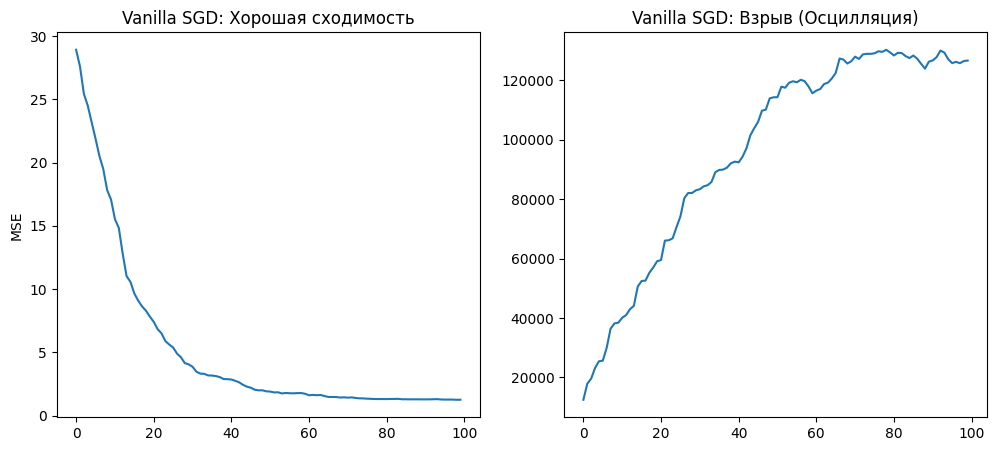

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist_good[:100])
plt.title("Vanilla SGD: Хорошая сходимость")
plt.ylabel("MSE")

plt.subplot(1, 2, 2)
plt.plot(hist_bad[:100])
plt.title("Vanilla SGD: Взрыв (Осцилляция)")
plt.show()

In [ ]:
class OptimizersShowdown:
    def __init__(self, X, y):
        self.X_b = np.c_[np.ones((len(y), 1)), X]
        self.y = y
        self.m = len(y)

    def solve(self, opt_type='adam', epochs=100, lr=0.01):
        w = np.random.randn(2, 1)
        history = []
        beta1, beta2 = 0.9, 0.999    # Для Adam
        eps = 1e-8
        m_t, v_t = np.zeros_like(w), np.zeros_like(w) # Adam moments
        s_t = np.zeros_like(w)       # RMSProp
        edelta_t = np.zeros_like(w)  # AdaDelta (accumulated updates)
        eg_t = np.zeros_like(w)      # AdaDelta (accumulated gradients)

        for t in range(1, epochs + 1):
            idx = np.random.randint(self.m)
            xi, yi = self.X_b[idx:idx+1], self.y[idx:idx+1]
            g = 2 * xi.T.dot(xi.dot(w) - yi)

            if opt_type == 'rmsprop':
                s_t = 0.9 * s_t + 0.1 * g**2
                w -= lr * g / (np.sqrt(s_t) + eps)

            elif opt_type == 'adadelta':
                eg_t = 0.9 * eg_t + 0.1 * g**2
                delta_w = - (np.sqrt(edelta_t + eps) / np.sqrt(eg_t + eps)) * g
                w += delta_w
                edelta_t = 0.9 * edelta_t + 0.1 * delta_w**2

            elif opt_type == 'adam':
                m_t = beta1 * m_t + (1 - beta1) * g
                v_t = beta2 * v_t + (1 - beta2) * g**2
                m_hat = m_t / (1 - beta1**t)
                v_hat = v_t / (1 - beta2**t)
                w -= lr * m_hat / (np.sqrt(v_hat) + eps)

            history.append(np.mean((self.X_b.dot(w) - self.y)**2))
        return history

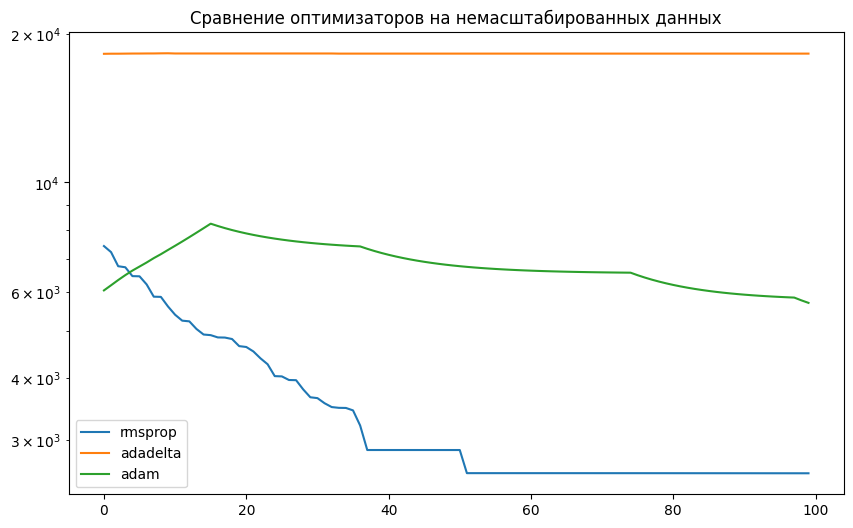

In [ ]:
opt = OptimizersShowdown(X_bad, y)
plt.figure(figsize=(10, 6))
for name in ['rmsprop', 'adadelta', 'adam']:
    plt.plot(opt.solve(name), label=name)
plt.yscale('log')
plt.legend()
plt.title("Сравнение оптимизаторов на немасштабированных данных")
plt.show()

In [ ]:
# Model 1
X_lin = np.linspace(0, 10, 100)
y_lin = 3 * X_lin + 5 + np.random.normal(0, 2, 100)
w_lin = np.polyfit(X_lin, y_lin, 1)
preds_lin = w_lin[0]*X_lin + w_lin[1]
residuals_lin = y_lin - preds_lin

In [ ]:
# Model 2
X_curve = np.linspace(-5, 5, 100)
y_curve = X_curve**2 + np.random.normal(0, 2, 100) # Квадратичная зависимость
w_bad_lin = np.polyfit(X_curve, y_curve, 1) # Обучаем прямую
preds_bad = w_bad_lin[0]*X_curve + w_bad_lin[1]
residuals_bad = y_curve - preds_bad

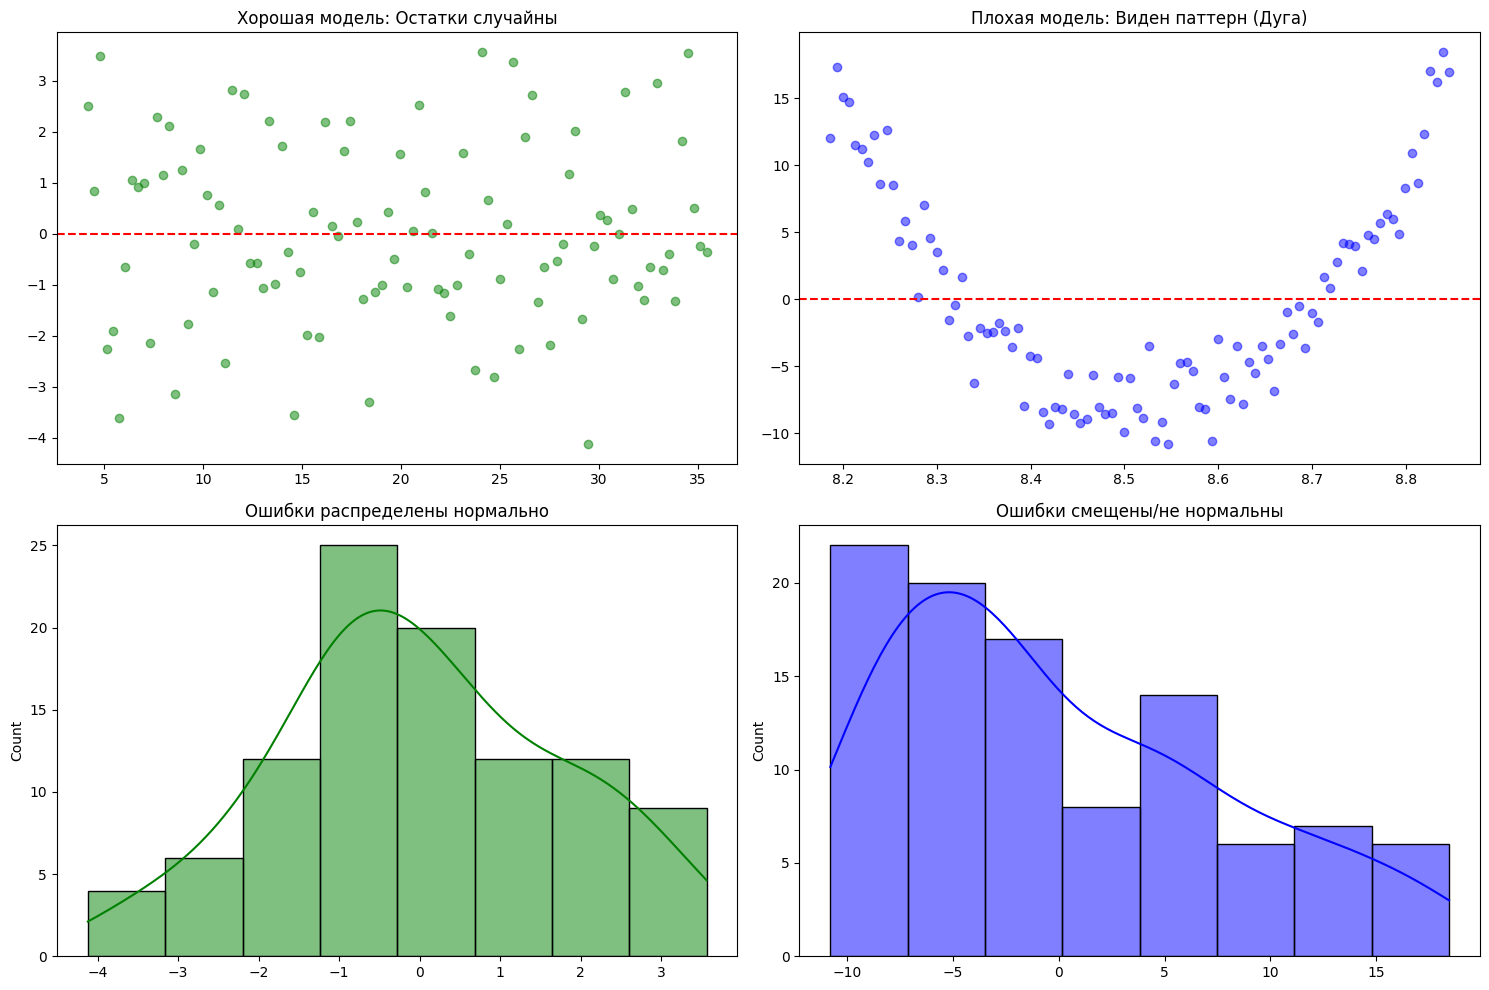

In [ ]:
# Residuals
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].scatter(preds_lin, residuals_lin, color='green', alpha=0.5)
axes[0,0].axhline(0, color='red', linestyle='--')
axes[0,0].set_title("Хорошая модель: Остатки случайны")

axes[0,1].scatter(preds_bad, residuals_bad, color='blue', alpha=0.5)
axes[0,1].axhline(0, color='red', linestyle='--')
axes[0,1].set_title("Плохая модель: Виден паттерн (Дуга)")

# Гистограммы распределения ошибок
sns.histplot(residuals_lin, kde=True, ax=axes[1,0], color='green')
axes[1,0].set_title("Ошибки распределены нормально")

sns.histplot(residuals_bad, kde=True, ax=axes[1,1], color='blue')
axes[1,1].set_title("Ошибки смещены/не нормальны")

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.datasets import make_regression

In [ ]:
# Генерация данных
np.random.seed(42)
X = np.sort(np.random.rand(200, 1) * 6 - 3, axis=0)
# Нелинейная зависимость: y = 0.5*x^3 - x^2 + 2*x + шум
y = 0.5 * X**3 - X**2 + 2 * X + np.random.normal(0, 2, size=(200, 1))

In [ ]:
# Подготовка признаков (Полином 3-й степени)
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)

# Масштабирование (Критически важно для стабильности градиентов)
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Конвертация в тензоры PyTorch
X_tensor = torch.tensor(X_poly_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

In [ ]:
# Обучение
def train_model(optimizer_class, lr=0.1, epochs=200):
    # Модель: Линейный слой (вход 3 признака: x, x^2, x^3)
    model = nn.Linear(3, 1)
    # Инициализируем оптимизатор
    optimizer = optimizer_class(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    loss_history = []

    for epoch in range(epochs):
        # Прямой проход
        y_pred = model(X_tensor)
        loss = criterion(y_pred, y_tensor)

        # Обратный проход и оптимизация
        optimizer.zero_grad() # Обнуляем градиенты с прошлого шага
        loss.backward()       # Считаем градиенты
        optimizer.step()      # Обновляем веса

        loss_history.append(loss.item())

    return model, loss_history

In [ ]:
# Vanilla SGD (в PyTorch это SGD без моментума)
model_sgd, hist_sgd = train_model(torch.optim.SGD, lr=0.01)
# RMSProp
model_rmsprop, hist_rmsprop = train_model(torch.optim.RMSprop, lr=0.01)
# Adam
model_adam, hist_adam = train_model(torch.optim.Adam, lr=0.1)

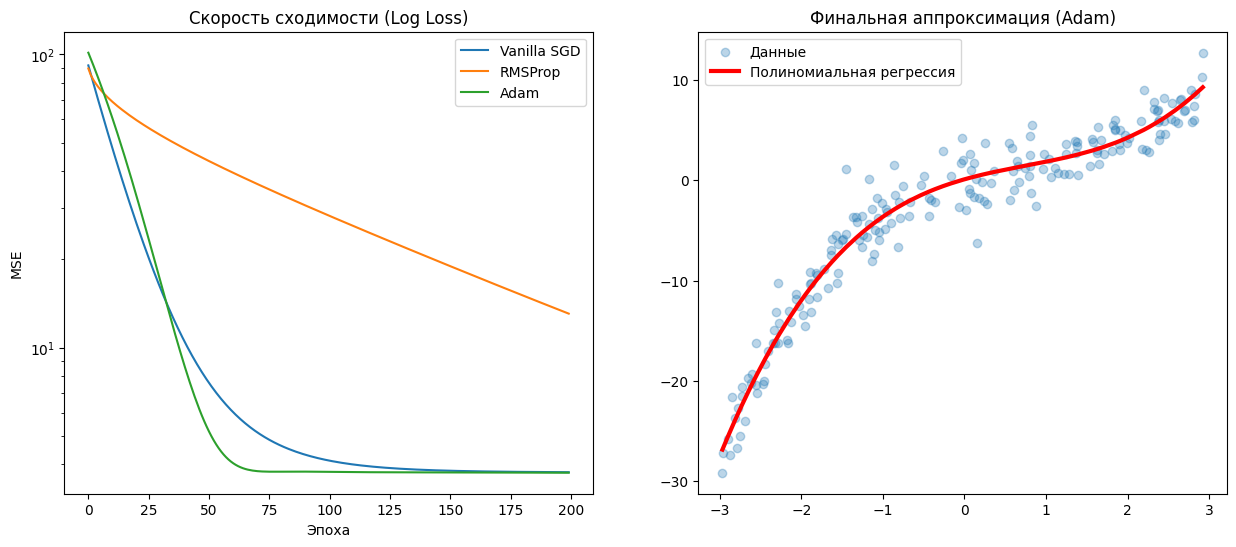

In [ ]:
# Визуализация результатов
plt.figure(figsize=(15, 6))

# График сходимости (Loss)
plt.subplot(1, 2, 1)
plt.plot(hist_sgd, label='Vanilla SGD')
plt.plot(hist_rmsprop, label='RMSProp')
plt.plot(hist_adam, label='Adam')
plt.yscale('log')
plt.title("Скорость сходимости (Log Loss)")
plt.xlabel("Эпоха")
plt.ylabel("MSE")
plt.legend()

# График предсказаний лучшей модели (Adam)
plt.subplot(1, 2, 2)
plt.scatter(X, y, alpha=0.3, label='Данные')
with torch.no_grad():
    y_final = model_adam(X_tensor)
plt.plot(X, y_final, color='red', lw=3, label='Полиномиальная регрессия')
plt.title("Финальная аппроксимация (Adam)")
plt.legend()
plt.show()

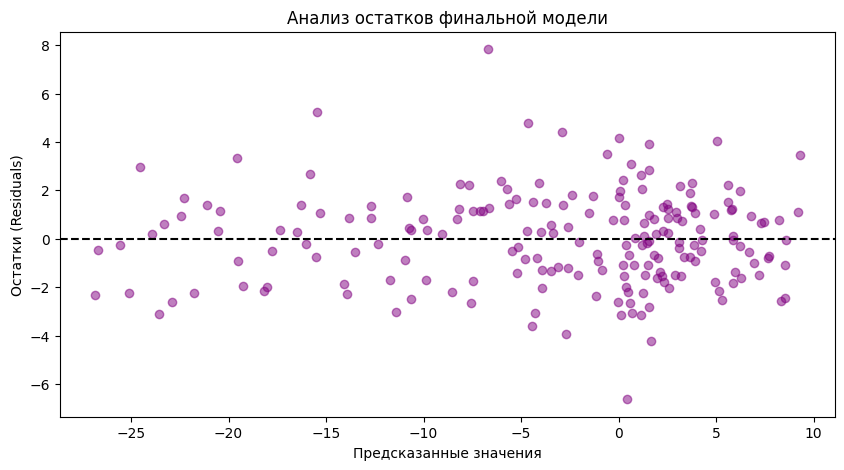

In [ ]:
# Анализ остатков
with torch.no_grad():
    residuals = (y_tensor - model_adam(X_tensor)).numpy()
    preds = model_adam(X_tensor).numpy()

plt.figure(figsize=(10, 5))
plt.scatter(preds, residuals, alpha=0.5, color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title("Анализ остатков финальной модели")
plt.xlabel("Предсказанные значения")
plt.ylabel("Остатки (Residuals)")
plt.show()

# Лабораторная работа

California Housing (цены на жилье в Калифорнии)
https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [ ]:
'''
1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea
'''

'\n1. longitude: A measure of how far west a house is; a higher value is farther west\n2. latitude: A measure of how far north a house is; a higher value is farther north\n3. housingMedianAge: Median age of a house within a block; a lower number is a newer building\n4. totalRooms: Total number of rooms within a block\n5. totalBedrooms: Total number of bedrooms within a block\n6. population: Total number of people residing within a block\n7. households: Total number of households, a group of people residing within a home unit, for a block\n8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)\n9. medianHouseValue: Median house value for households within a block (measured in US Dollars)\n10. oceanProximity: Location of the house w.r.t ocean/sea\n'

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [ ]:
# Загрузка данных
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df = df.drop(['AveBedrms', 'Longitude'], axis=1)
df['MedHouseVal'] = data.target
print(df['MedHouseVal'].max())
count = (df['MedHouseVal'] == 5.00001).sum()
print(f"Число строк: {count}")

5.00001
Число строк: 965


In [ ]:
df['MedHouseVal'].head()

,MedHouseVal
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422


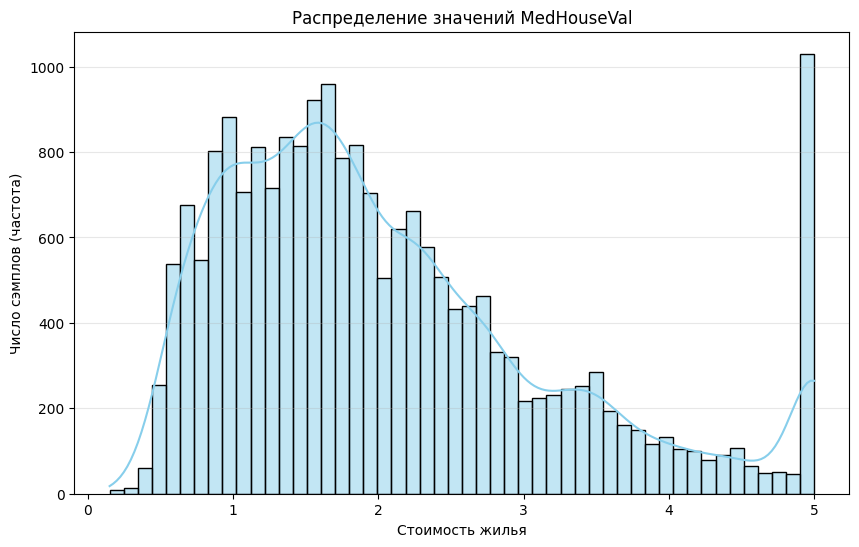

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['MedHouseVal'], bins=50, kde=True, color='skyblue')

plt.title('Распределение значений MedHouseVal')
plt.xlabel('Стоимость жилья')
plt.ylabel('Число сэмплов (частота)')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:
print(f"Формат данных: {df.shape}")
print(df.head())

Формат данных: (20640, 7)
   MedInc  HouseAge  AveRooms  Population  AveOccup  Latitude  MedHouseVal
0  8.3252      41.0  6.984127       322.0  2.555556     37.88        4.526
1  8.3014      21.0  6.238137      2401.0  2.109842     37.86        3.585
2  7.2574      52.0  8.288136       496.0  2.802260     37.85        3.521
3  5.6431      52.0  5.817352       558.0  2.547945     37.85        3.413
4  3.8462      52.0  6.281853       565.0  2.181467     37.85        3.422


In [ ]:
# Подготовка для градиентного спуска
X = df.drop('MedHouseVal', axis=1).values
y = df['MedHouseVal'].values.reshape(-1, 1)
X

array([[8.32520000e+00, 4.10000000e+01, 6.98412698e+00, 3.22000000e+02,
        2.55555556e+00, 3.78800000e+01],
       [8.30140000e+00, 2.10000000e+01, 6.23813708e+00, 2.40100000e+03,
        2.10984183e+00, 3.78600000e+01],
       [7.25740000e+00, 5.20000000e+01, 8.28813559e+00, 4.96000000e+02,
        2.80225989e+00, 3.78500000e+01],
       ...,
       [1.70000000e+00, 1.70000000e+01, 5.20554273e+00, 1.00700000e+03,
        2.32563510e+00, 3.94300000e+01],
       [1.86720000e+00, 1.80000000e+01, 5.32951289e+00, 7.41000000e+02,
        2.12320917e+00, 3.94300000e+01],
       [2.38860000e+00, 1.60000000e+01, 5.25471698e+00, 1.38700000e+03,
        2.61698113e+00, 3.93700000e+01]])

In [ ]:
# Разбиение на train/test


In [ ]:
# Масштабирование
scaler = StandardScaler()


In [ ]:
# Конвертация в тензоры PyTorch
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Создание модели с регуляризацией
# L2-регуляризация в PyTorch задается параметром weight_decay в оптимизаторе
model = nn.Linear(X_train.shape[1], 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01) # weight_decay = L2
criterion = nn.MSELoss()

In [ ]:
# Цикл обучения (Batch Gradient Descent)
epochs = 500
history = []

for epoch in range(epochs):
    # Forward

    # Backward

    history.append(loss.item())
    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [100/500], Loss: 0.6184
Epoch [200/500], Loss: 0.6184
Epoch [300/500], Loss: 0.6184
Epoch [400/500], Loss: 0.6184
Epoch [500/500], Loss: 0.6184


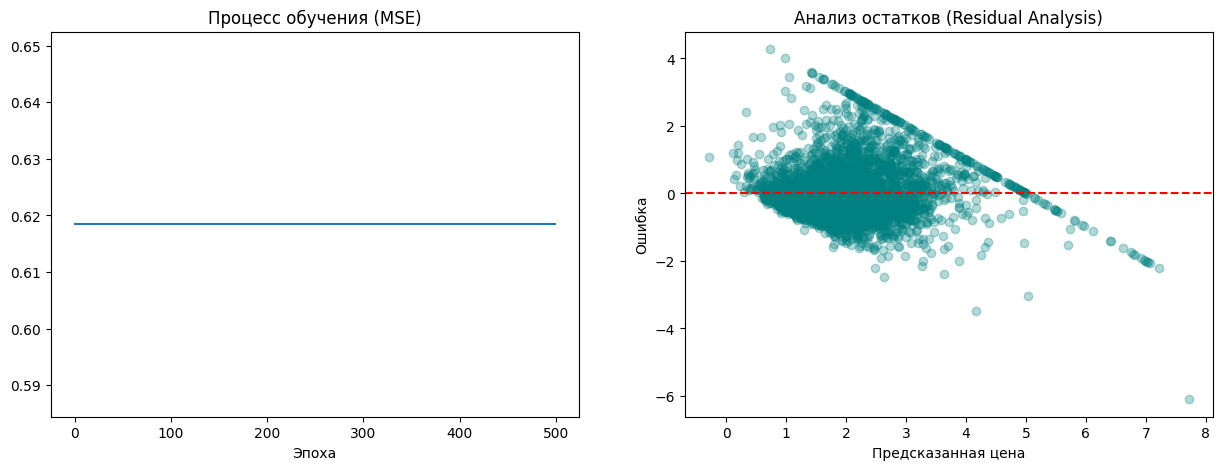

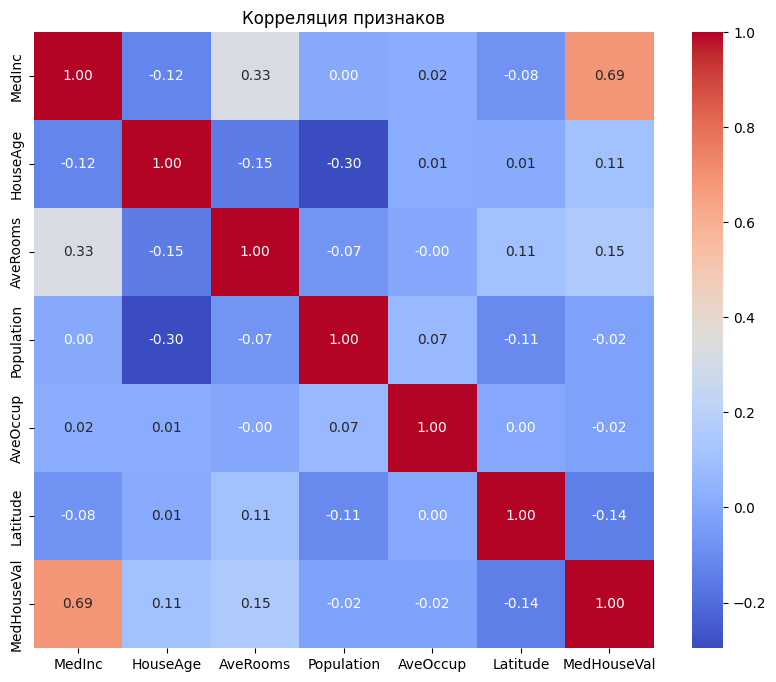

In [ ]:
plt.figure(figsize=(15, 5))

# График обучения
plt.subplot(1, 2, 1)
plt.plot(history)
plt.title("Процесс обучения (MSE)")
plt.xlabel("Эпоха")

# Анализ остатков
with torch.no_grad():
    test_preds = model(X_test_t).numpy()
    residuals = y_test - test_preds

plt.subplot(1, 2, 2)
plt.scatter(test_preds, residuals, alpha=0.3, color='teal')
plt.axhline(0, color='red', linestyle='--')
plt.title("Анализ остатков (Residual Analysis)")
plt.xlabel("Предсказанная цена")
plt.ylabel("Ошибка")
plt.show()

# Корреляционная матрица для EDA
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Корреляция признаков")
plt.show()

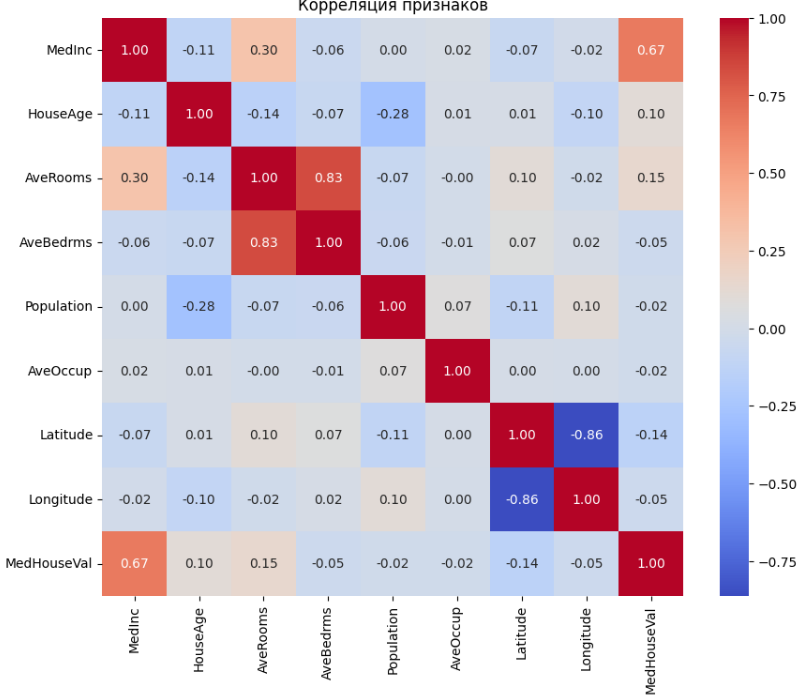